In [1]:
import json
import numpy as np

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('sentiwordnet')

from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from afinn import Afinn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import custom_lexicons.senticnet.senticnet as sentic

import numpy as np 
import pandas as pd
import data_reader
import results_analyser
import itertools

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\phoec\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\phoec\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\phoec\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [2]:
FILE_DIR = "./custom_lexicons/"

NTUSD_FILEPATH = "ntusd/NTUSD_Fin_word_v1.0.json"
STOCKTWITLEXI_FILEPATH = "stocktwitlexi/domain_lexicon_raw_norm.csv"
SENTI_DD_FILEPATH = "sentidd/sentidd_data1.csv"
LM_FILEPATH = "sentidd/LM_Word_List.csv"

# AFINN
afinn = Afinn()

# VADER
analyzer = SentimentIntensityAnalyzer()

# NTUSD-FIN
with open(FILE_DIR+NTUSD_FILEPATH, "r") as f:
    data = f.read()
    NTUSD = json.loads(data)
word_sent_dict = {}
for i in range(len(NTUSD)):
    word_sent_dict[NTUSD[i]["token"]] = NTUSD[i]["market_sentiment"]
    
# STOCKTWITLEXI    
stocktwitlexi = pd.read_csv(FILE_DIR+STOCKTWITLEXI_FILEPATH, header=None, index_col=0)
stocktwitlexi = stocktwitlexi.to_dict()[1]

# SENTIDD
sentidd = pd.read_csv(FILE_DIR+SENTI_DD_FILEPATH)
sentidd_dict = dict(zip(zip(sentidd.entity, sentidd.directional_word), sentidd.sentiment))
lm_df = pd.read_csv(FILE_DIR+LM_FILEPATH)
lm_dict = dict(zip(lm_df.word, lm_df.label))

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def remove_stopwords(data):
    sentence_token = [s.split(' ') for s in data] 
    return sentence_token

def get_wordnet_tag(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

In [3]:
def standardise_scores(score, count):
    if (count>0):
        return score/count
    else:
        return score

def normalise_scores(pred_raw, lexicon):
    if(lexicon=="senticnet"): #-1 to 1
        return pred_raw
    elif(lexicon=="ntusd"): #-3.81 to 1.22, range is 5 so /2.5
        return [pred/2.5 for pred in pred_raw]
    elif(lexicon=="sentiwordnet"): #-1 to 1 since pos-neg
        return pred_raw
    elif(lexicon=="stocktwitlexi"): #-1 to 1
        return pred_raw
    elif(lexicon=="afinn"): #-5 to 5
        return [pred/5 for pred in pred_raw]
    elif(lexicon=="vader"): #-1 to 1
        return pred_raw
    elif(lexicon=="sentidd"): #-2 to 2
        return [pred/2 for pred in pred_raw]

In [4]:
def senti_dd_polarity(text, sentidd_dict, lm_dict):
    def lm_score(text, lm_dict):
        tokens = word_tokenize(text)
        count = 0
        score = 0
        for token in tokens:
            try:
                if lm_dict[token]=="positive":
                    score += 1
                    count += 1
                elif lm_dict[token]=="negative":
                    score -= 1
                    count += 1
            except:
                pass

        return score/count if count>0 else score

    def senti_dd_score(text, sentidd_dict):
        tokens = word_tokenize(text)
        count = 0
        score = 0
        stemmed_tokens = [stemmer.stem(token) for token in tokens]
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        for stemmed_token in stemmed_tokens:
            for lemmatized_token in lemmatized_tokens:
                
                try:
                    if (sentidd_dict[(lemmatized_token, stemmed_token)] =="positive"):
                        score += 1
                        count += 1
                    elif (sentidd_dict[(lemmatized_token, stemmed_token)] =="negative"):
                        score -= 1
                        count += 1
                except:
                    pass
        return score/count if count>0 else score
    
    score = lm_score(text, lm_dict)
    context_sentiment_score = senti_dd_score(text, sentidd_dict)
    if context_sentiment_score > 0: score += 1
    elif context_sentiment_score < 0: score -= 1

    return score

In [5]:
def individual_scoring(X, y_class):
    sentic_pred_raw = []
    ntusd_pred_raw = []
    sentiwordnet_pred_raw = []
    stocktwitlexi_pred_raw = []
    afinn_pred_raw = []
    vader_pred_raw = []
    sentidd_pred_raw = []
    
    for test_tweet in X:
        sentic_score = 0
        ntusd_score = 0
        sentiwordnet_score = 0
        stocktwitlexi_score = 0
        afinn_score = 0
        
        sentic_count = 0
        ntusd_count = 0
        sentiwordnet_count = 0
        stocktwitlexi_count = 0
        afinn_count = 0
        
        sentence_tagged = np.array(nltk.pos_tag(test_tweet))
        for tagged in sentence_tagged:
            word = tagged[0]
            wn_tag = get_wordnet_tag(tagged[1])
            
            #Senticnet
            try: 
                sentic_score += sentic.senticnet[word][7]
                sentic_count += 1
            except:
                pass
            #NTUSD
            try: 
                ntusd_score += word_sent_dict[word]
                ntusd_count += 1
            except:
                pass
            
            #Senticwordnet
            if wn_tag in (wn.NOUN, wn.ADJ, wn.ADV,  wn.VERB):            
                lemma = lemmatizer.lemmatize(word, pos=wn_tag)
                if lemma:
                    synsets = wn.synsets(lemma, pos=wn_tag)
                    if synsets:
                        swn_synset = swn.senti_synset(synsets[0].name())
                        sentiwordnet_score += swn_synset.pos_score() - swn_synset.neg_score()
                        sentiwordnet_count += 1
            #Stocktwitlexi
            try: 
                stocktwitlexi_score += stocktwitlexi[word]
                stocktwitlexi_count += 1
            except:
                pass
            
            #Afinn
            try: 
                afinn_score += afinn.score(word)
                afinn_count += 1
            except:
                pass
        
        #Afinn
        s = " ".join(test_tweet)
        
        #Vader
        vader_output = analyzer.polarity_scores(s)
        vader_score = vader_output["compound"] #vader_output["pos"] - vader_output["neg"]
        
        #Senti-DD
        sentidd_score = senti_dd_polarity(s, sentidd_dict, lm_dict)
        
        sentic_score = standardise_scores(sentic_score, sentic_count)
        ntusd_score = standardise_scores(ntusd_score, ntusd_count)
        sentiwordnet_score = standardise_scores(sentiwordnet_score, sentiwordnet_count)
        stocktwitlexi_score = standardise_scores(stocktwitlexi_score, stocktwitlexi_count)
        afinn_score = standardise_scores(afinn_score, afinn_count)
        vader_score = vader_score #already normalised
        sentidd_score = sentidd_score #already normalised
        
        sentic_pred_raw.append(sentic_score)
        ntusd_pred_raw.append(ntusd_score)
        sentiwordnet_pred_raw.append(sentiwordnet_score)
        stocktwitlexi_pred_raw.append(stocktwitlexi_score)
        afinn_pred_raw.append(afinn_score)
        vader_pred_raw.append(vader_score)
        sentidd_pred_raw.append(sentidd_score)
        
    sentic_pred = normalise_scores(sentic_pred_raw, "senticnet")
    ntusd_pred = normalise_scores(ntusd_pred_raw, "ntusd")
    sentiwordnet_pred = normalise_scores(sentiwordnet_pred_raw, "sentiwordnet")
    stocktwitlexi_pred = normalise_scores(stocktwitlexi_pred_raw, "stocktwitlexi")
    afinn_pred = normalise_scores(afinn_pred_raw, "afinn")
    vader_pred = normalise_scores(vader_pred_raw, "vader")
    sentidd_pred = normalise_scores(sentidd_pred_raw, "sentidd")

    combined_df = pd.DataFrame()
    combined_df['senticnet'] = sentic_pred
    combined_df['ntusd'] = ntusd_pred
    combined_df['sentiwordnet'] = sentiwordnet_pred
    combined_df['afinn'] = afinn_pred
    combined_df['vader'] = vader_pred
    combined_df['stocktwitlexi'] = stocktwitlexi_pred
    combined_df['sentidd'] = sentidd_pred
    combined_df['actual_class'] = y_class
    
    return combined_df

In [6]:
def combine_voting_leave2soft(row):
    lowest_col = row.sort_values().idxmin()
    highest_col = row.sort_values().idxmax()
    lowest_dict[lowest_col] += 1
    highest_dict[highest_col] += 1
    return row.sort_values().iloc[1:4].mean()

def combine_voting_soft(row):
    return row.sort_values().mean()

def combine_voting_hard(row):
    pos_vote = (row > 0).sum()
    neg_vote = (row <= 0).sum()
    return 1 if pos_vote>neg_vote else 0

In [7]:
def generate_results(combined_df):
    combination_list = []
    lexicons = ["senticnet", "ntusd", "sentiwordnet", "stocktwitlexi", "afinn", "vader", "sentidd"]

    for i in range(1, len(lexicons)+1):
        combination_tuples = list(itertools.combinations(lexicons, i))
        combination_list.extend([list(elem) for elem in combination_tuples])

    y_class = combined_df['actual_class']
    results_df = pd.DataFrame()

    for combination in combination_list:
        curr_df = combined_df[combination]

        if(len(combination)>1): #more than 1
            voting_soft = curr_df.apply(combine_voting_soft, axis=1)
            pred_class = results_analyser.probability_to_class(voting_soft)
            results_df = results_analyser.calculate_metrics(results_df, y_class, pred_class, '_'.join(combination)+"_soft")

            if(len(combination)%2==1): #odd number
                voting_hard = curr_df.apply(combine_voting_hard, axis=1)
                results_df = results_analyser.calculate_metrics(results_df, y_class, voting_hard, '_'.join(combination)+"_hard")

            if(len(combination)>=5 and len(combination)%2==1): #odd and gte 5
                voting_leave2soft = curr_df.apply(combine_voting_leave2soft, axis=1)
                pred_class = results_analyser.probability_to_class(voting_leave2soft)
                results_df = results_analyser.calculate_metrics(results_df, y_class, pred_class, '_'.join(combination)+"_leave2soft")
        else:
            pred_class = results_analyser.probability_to_class(combined_df[combination[0]])
            results_df = results_analyser.calculate_metrics(results_df, y_class, pred_class, '_'.join(combination))

    return results_df

## Pre analysis

2 main issues:
1. Unable to capture relavant concept
2. Concept captured but scoring isnt reflective of it

In [121]:
pd.set_option('display.max_colwidth', None)

In [128]:
df = pd.read_csv("./results/baseline_analysis_twitter.csv")
df = df[['tweettextcleaned', 'sentic_polarity', 'sentic_concept']]
df.head(60)

,tweettextcleaned,sentic_polarity,sentic_concept
0,"Inflation at an all time high, interest at an all time low. Fiscal policy, monetary policy, foreign policy, domestic policy, energy policy, labor policy, trade policy, manufacturing policy, and healthcare policy are all inflationary. Bitcoin is hope.",POSITIVE,"['trade policy', 'fiscal policy', 'monetary policy', 'inflation', 'time', 'interest', 'low', 'policy', 'domestic', 'energy', 'healthcare', 'inflationary', 'hope']"
1,"Rather than maintain a narrow focus on managing the money supply, the Fed is now figuratively all over the shop, its fingerprints evident everywhere across the economy. READ Escape from Jekyll Island FederalReserve inflation fintwit",POSITIVE,"['shop', 'focus on', 'maintain', 'narrow', 'money', 'supply', 'figuratively', 'fingerprint', 'evident', 'everywhere', 'economy', 'escape', 'inflation']"
2,FED rate hike Gold rise Commodities soar Not-so-transitory inflation And worst of all WAR! Things are volatile. But your investment portfolio doesn't have to be! - The unique digital asset that brings you the best of both worlds Gold &amp; Crypto.,POSITIVE,"['investment portfolio', 'digital asset', 'worst of', 'rate', 'hike', 'gold', 'rise', 'soar', NOT 'transitory', 'inflation', 'war', 'volatile', 'unique', 'brings', 'best']"
3,"Every day that inflation remains elevated the Fed gets put in an even more difficult place - that much closer to a policy error. Hike rates into a slowing economy - ouch, dont hike rates - inflation continues to crush the middle class.",NEGATIVE,"['place', 'middle class', 'slowing economy', 'inflation', 'remain', 'difficult', 'closer', 'policy', 'error', NOT 'hike', 'rate', 'ouch', 'continue', 'crush']"
4,"Fed Chair Powell just reassured Congress that inflation would continue to decline throughout the year. What does he mean by continue? Inflation is not declining now, it's actually accelerating. Based on that acceleration it looks like the inflation rate will increase in 2022!",NEGATIVE,"['inflation rate', 'reassured', 'inflation', 'continue', 'decline', 'acceleration', 'increase']"
5,"'Shelby Volcker put the economy in a recession to get inflation under control. ""Are you prepared to do what it takes to get inflation under control?"" Powell ""I hope history will record that the answer to your question is yes.""' will the fed force a recession? I believe so",POSITIVE,"['economy', 'recession', 'inflation', NOT 'control', 'prepared', 'hope', 'record', 'answer', 'yes', 'force', 'believe']"
6,"When asked how the Fed will fight historically high inflation without harming the economy or causing a recession, Powell said The Fed will raise interest rates and reduce its balance sheet, but do so with care. That means the Fed will cease doing both once the harm is obvious!",NEGATIVE,"['interest rate', 'balance sheet', 'fight', 'historically', 'inflation', NOT 'harm', 'economy', 'causing', 'recession', 'raise', 'reduce', 'care', 'cease', 'obvious']"
7,"Powell admitted price rises will be permanent. The Fed's only goal is to eventually bring future price increases back down to 2% per year. If Fed policy is still for inflation to average 2% over time, it must hold inflation well below 2% for a many years to achieve that goal.",POSITIVE,"['price', 'achieve goal', 'admitted', 'rises', 'permanent', 'goal', 'eventually', 'policy', 'inflation', 'average', NOT 'time', 'hold']"
8,"*FED MESTER THERE'S A LIKELIHOOD THAT A SUBSTANTIAL INCREASE IN ENERGY PRICES, AS WELL AS SUPPLY CHAIN ISSUES, WILL PERSIST FOR A LONGER PERIOD OF TIME, INCREASING THE RISK OF HIGH INFLATION BECOMING ENTRENCHED IN THE US. Ten months of Doomberg in one headline",POSITIVE,"['likelihood', 'increase', 'energy', 'supply', 'chain', 'issues', 'persist', 'longer', 'time', 'risk', 'inflation']"
9,$SPY $QQQ I will keep it simple. Were in a downtrend on $QQQ $SPY $DIA. Raise cash to weather the storm. Pressure will build to close the sanction loopholes Russian oil and gas and cryptocurrency. 

In [183]:
df.iloc[[18,21,27,29,40,47,48,55]].reset_index(drop=True)

,tweettextcleaned,sentic_polarity,sentic_concept
0,The Fed is going to fight inflation - and lose.,POSITIVE,"['fight', 'inflation', 'lose']"
1,"Since August 20, 2021, - Lumber is up over 157% - Bitcoin is down over 13% - US national debt increased to over $30 trillion - Inflation jumped to over 7.5%, a 40 year high - The Fed remains clueless And stocks might soon crash. Few understand this. Click Follow for more",POSITIVE,"['lumber', 'debt', 'increased', 'inflation', 'jumped', 'high', 'remain', NOT 'clue', 'stocks', 'crash', 'understand', 'click', 'follow']"
2,For the first time during this crisis there are rumors the FED is internally considering forgoing the rate hike completely in March. If this happens markets will rip.,NEGATIVE,"['time', 'crisis', 'rumors', 'internally', 'consider', 'forgo', 'rate', 'hike', 'complete', 'hap', 'rip']"
3,"Following FOMC today, market will likely realise 1) Fed will begin to taper - and soon! 2) Tapering is not tightening (bubble can inflate further - weeks/months. And down the road. 3) This is first step on tapering/hiking cycle which will eventually pop the Everything Bubble",POSITIVE,"['follow', 'real', 'beg', 'taper', NOT 'tighten', 'bubble', 'inflate', 'hiking', 'cycle', 'eventually', 'pop']"
4,"""We should have moved earlier,"" says the man (Jerome Powell), who still hasn't moved and won't move as far as he could and should. Great.",POSITIVE,"['man', NOT 'moved', 'early', NOT 'move', 'great']"
5,"FED Jerome Powell ""inflation is transitory."" Quote of the decade",POSITIVE,"['inflation', 'transitory', 'quote', 'decade']"
6,"Russia's war on Ukraine is likely to raise inflation and lower investment, energy prices to affect US economy in form of higher inflation in short term, US Federal Reserve Chair Jerome Powell said",POSITIVE,"['in form', 'war', 'raise', 'inflation', 'lower', 'investment', 'energy', 'affect', 'economy', 'short', 'federal', 'reserve']"
7,"Russia's war on Ukraine will worsen inflation, says Fed's Jerome Powell Consumer prices are already rising at their fastest pace in four decades, having jumped 7.5 per cent in January compared with 12 months earlier Top Stories by BusinessStandard",POSITIVE,"['war', 'worsen', 'inflation', 'consumer', 'rising', 'fastest', 'pace', 'decade', 'jumped', 'cent', 'compare', 'early', 'top']"


## Post analysis

### Read in Data2 and 3, combine them both

In [161]:
data2_X, data2_y_class = data_reader.read_data2("list")
data3_X, data3_y_class = data_reader.read_data3("list")

data2_X.extend(data3_X)
data2_y_class.extend(data3_y_class)

In [162]:
len(data2_X)

2036

### Get individual Scores

In [163]:
combined_df = individual_scoring(data2_X, data2_y_class)
senticnet_finegrained = combined_df['senticnet']
combined_df

,senticnet,ntusd,sentiwordnet,afinn,vader,stocktwitlexi,sentidd,actual_class
0,0.302600,-0.084072,0.015625,0.038095,0.5859,0.062336,0.5,1
1,-0.126786,0.131360,0.017045,-0.005263,0.2023,0.088886,-0.5,0
2,0.137750,0.026968,-0.013158,-0.024242,-0.7351,0.088475,0.0,1
3,0.857500,0.286495,0.020833,0.018182,0.3818,0.089604,0.0,1
4,0.854500,0.309721,0.015625,0.040000,0.6249,0.116167,0.5,1
...,...,...,...,...,...,...,...,...
2031,0.446667,-0.015374,-0.093750,-0.027273,-0.0783,0.095814,-0.5,0
2032,0.024500,-0.425183,-0.062500,0.000000,0.0000,0.088961,0.0,0
2033,0.472500,-0.472243,0.000000,-0.100000,-0.3182,-0.134641,0.0,0
2034,0.879000,-0.260604,0.000000,0.000000,0.0000,0.090518,0.0,0


### Combine w input text

In [164]:
combined_df['text'] = [" ".join(l) for l in data2_X]
combined_df

,senticnet,ntusd,sentiwordnet,afinn,vader,stocktwitlexi,sentidd,actual_class,text
0,0.302600,-0.084072,0.015625,0.038095,0.5859,0.062336,0.5,1,rt yo enter to win monarch tokens us stock market crashes what we can learn from them pt retweet watch video
1,-0.126786,0.131360,0.017045,-0.005263,0.2023,0.088886,-0.5,0,srilanka surcharge on fuel removed the surcharge of rs imposed on diesel and petrol has been revoked with effect from midnight on june says power energy and transport minister mahinda amaraweera adaderana lka fuelprices taxes economy stocks stockmarket
2,0.137750,0.026968,-0.013158,-0.024242,-0.7351,0.088475,0.0,1,net issuance increases to fund fiscal programs yields spike higher risk off stocks and emfx correct lower fed comes in with ycc stocks to new all time highs with unemployment and gdp fin
3,0.857500,0.286495,0.020833,0.018182,0.3818,0.089604,0.0,1,rt how much of amazons traffic is served by fastly help us find out by running this tool from your ip address
4,0.854500,0.309721,0.015625,0.040000,0.6249,0.116167,0.5,1,ryzen desktop cpus looking great and on track to launch in madtweets stocks cnbc amd
...,...,...,...,...,...,...,...,...,...
2031,0.446667,-0.015374,-0.093750,-0.027273,-0.0783,0.095814,-0.5,0,while all other cryptos are rising and shining this pos is no hard feelings just stopping by to see how yall doing
2032,0.024500,-0.425183,-0.062500,0.000000,0.0000,0.088961,0.0,0,glad i sold this crap hbar
2033,0.472500,-0.472243,0.000000,-0.100000,-0.3182,-0.134641,0.0,0,bull trap
2034,0.879000,-0.260604,0.000000,0.000000,0.0000,0.090518,0.0,0,team bear


### Get sentiment class from fine-grained results

In [165]:
lexicons = ["senticnet", "ntusd", "sentiwordnet", "stocktwitlexi", "afinn", "vader", "sentidd"]

for lexicon in lexicons:
    combined_df[lexicon] = results_analyser.probability_to_class(combined_df[lexicon])
    
combined_df

,senticnet,ntusd,sentiwordnet,afinn,vader,stocktwitlexi,sentidd,actual_class,text
0,1,0,1,1,1,1,1,1,rt yo enter to win monarch tokens us stock market crashes what we can learn from them pt retweet watch video
1,0,1,1,0,1,1,0,0,srilanka surcharge on fuel removed the surcharge of rs imposed on diesel and petrol has been revoked with effect from midnight on june says power energy and transport minister mahinda amaraweera adaderana lka fuelprices taxes economy stocks stockmarket
2,1,1,0,0,0,1,0,1,net issuance increases to fund fiscal programs yields spike higher risk off stocks and emfx correct lower fed comes in with ycc stocks to new all time highs with unemployment and gdp fin
3,1,1,1,1,1,1,0,1,rt how much of amazons traffic is served by fastly help us find out by running this tool from your ip address
4,1,1,1,1,1,1,1,1,ryzen desktop cpus looking great and on track to launch in madtweets stocks cnbc amd
...,...,...,...,...,...,...,...,...,...
2031,1,0,0,0,0,1,0,0,while all other cryptos are rising and shining this pos is no hard feelings just stopping by to see how yall doing
2032,1,0,0,0,0,1,0,0,glad i sold this crap hbar
2033,1,0,0,0,0,0,0,0,bull trap
2034,1,0,0,0,0,1,0,0,team bear


### Get number of votes with or against senticnet

In [166]:
combined_df['vote0'] = (combined_df[lexicons] == 0).astype(int).sum(axis=1)
combined_df['vote1'] = (combined_df[lexicons] == 1).astype(int).sum(axis=1)
combined_df

,senticnet,ntusd,sentiwordnet,afinn,vader,stocktwitlexi,sentidd,actual_class,text,vote0,vote1
0,1,0,1,1,1,1,1,1,rt yo enter to win monarch tokens us stock market crashes what we can learn from them pt retweet watch video,1,6
1,0,1,1,0,1,1,0,0,srilanka surcharge on fuel removed the surcharge of rs imposed on diesel and petrol has been revoked with effect from midnight on june says power energy and transport minister mahinda amaraweera adaderana lka fuelprices taxes economy stocks stockmarket,3,4
2,1,1,0,0,0,1,0,1,net issuance increases to fund fiscal programs yields spike higher risk off stocks and emfx correct lower fed comes in with ycc stocks to new all time highs with unemployment and gdp fin,4,3
3,1,1,1,1,1,1,0,1,rt how much of amazons traffic is served by fastly help us find out by running this tool from your ip address,1,6
4,1,1,1,1,1,1,1,1,ryzen desktop cpus looking great and on track to launch in madtweets stocks cnbc amd,0,7
...,...,...,...,...,...,...,...,...,...,...,...
2031,1,0,0,0,0,1,0,0,while all other cryptos are rising and shining this pos is no hard feelings just stopping by to see how yall doing,5,2
2032,1,0,0,0,0,1,0,0,glad i sold this crap hbar,5,2
2033,1,0,0,0,0,0,0,0,bull trap,6,1
2034,1,0,0,0,0,1,0,0,team bear,5,2


In [167]:
combined_df['vote_w_sn'] = combined_df.apply(lambda row: row['vote0']-1 if row['senticnet']==0 else row['vote1']-1, axis=1)
combined_df['vote_a_sn'] = combined_df.apply(lambda row: row['vote0'] if row['senticnet']==1 else row['vote1'], axis=1)
combined_df = combined_df.loc[:, ~combined_df.columns.isin(['vote0', 'vote1'])]
combined_df

,senticnet,ntusd,sentiwordnet,afinn,vader,stocktwitlexi,sentidd,actual_class,text,vote_w_sn,vote_a_sn
0,1,0,1,1,1,1,1,1,rt yo enter to win monarch tokens us stock market crashes what we can learn from them pt retweet watch video,5,1
1,0,1,1,0,1,1,0,0,srilanka surcharge on fuel removed the surcharge of rs imposed on diesel and petrol has been revoked with effect from midnight on june says power energy and transport minister mahinda amaraweera adaderana lka fuelprices taxes economy stocks stockmarket,2,4
2,1,1,0,0,0,1,0,1,net issuance increases to fund fiscal programs yields spike higher risk off stocks and emfx correct lower fed comes in with ycc stocks to new all time highs with unemployment and gdp fin,2,4
3,1,1,1,1,1,1,0,1,rt how much of amazons traffic is served by fastly help us find out by running this tool from your ip address,5,1
4,1,1,1,1,1,1,1,1,ryzen desktop cpus looking great and on track to launch in madtweets stocks cnbc amd,6,0
...,...,...,...,...,...,...,...,...,...,...,...
2031,1,0,0,0,0,1,0,0,while all other cryptos are rising and shining this pos is no hard feelings just stopping by to see how yall doing,1,5
2032,1,0,0,0,0,1,0,0,glad i sold this crap hbar,1,5
2033,1,0,0,0,0,0,0,0,bull trap,0,6
2034,1,0,0,0,0,1,0,0,team bear,1,5


### Split  into when senticnet predicted right or wrong

In [168]:
correct_df = combined_df.loc[(combined_df['senticnet'] == combined_df['actual_class'])]
wrong_df = combined_df.loc[(combined_df['senticnet'] != combined_df['actual_class'])]

### Countplot to visualise distribution of the number of lexicons that voted the same as senticnet

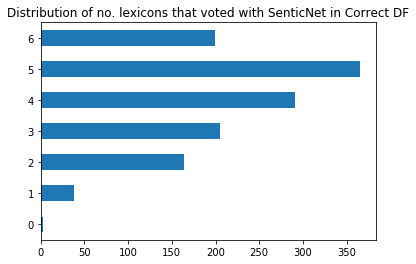

In [185]:
correct_df.vote_w_sn.value_counts().sort_index().plot(title = 'Distribution of no. lexicons that voted with SenticNet in Correct DF', kind = 'barh')

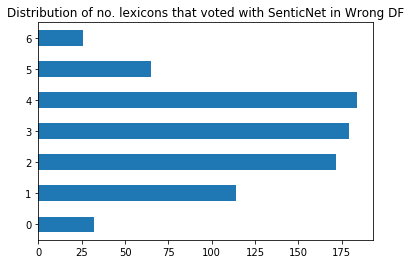

In [186]:
wrong_df.vote_w_sn.value_counts().sort_index().plot(title = 'Distribution of no. lexicons that voted with SenticNet in Wrong DF',kind = 'barh')

### Get instances where senticnet predicted wrong & all lexicons voted against it

In [171]:
wrong_allagainst_df = wrong_df.loc[(wrong_df['vote_w_sn'] == 0)]
wrong_allagainst_df['senticnet_finegrained'] = senticnet_finegrained.iloc[wrong_df.loc[(wrong_df['vote_w_sn'] == 1)].index]
wrong_allagainst_df

C:\Users\phoec\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,senticnet,ntusd,sentiwordnet,afinn,vader,stocktwitlexi,sentidd,actual_class,text,vote_w_sn,vote_a_sn,senticnet_finegrained
51,1,0,0,0,0,0,0,0,abg sundal collier tf bank ab tf bank loan loss level down bp qoq pbll in q slightly lower than abgsc and consensus loan loss level came in at bp down bp vs q share to outperform on loan loss relief equity stocks,0,6,NaN
160,0,1,1,1,1,1,1,1,rt happy wednesday here are my topthingstoknowtoday in financial markets earnings in the morning,0,6,NaN
258,0,1,1,1,1,1,1,1,dow futures up points on easing of coronavirus lockdowns as earnings season hits stride us stockindex futures rose tuesday with analysts citing progress toward easing coronavirus lockdowns a,0,6,NaN
302,0,1,1,1,1,1,1,1,growing vegetables spine gourd farming is profitable agriculture busin via depression usa community can try thanks trump,0,6,NaN
387,0,1,1,1,1,1,1,1,rt apple has bought back billion in stock over the past years which is greater than the market cap of companie,0,6,NaN
392,0,1,1,1,1,1,1,1,rt apple has bought back billion in stock over the past years which is greater than the market cap of companie,0,6,NaN
394,0,1,1,1,1,1,1,1,impressive,0,6,NaN
416,0,1,1,1,1,1,1,1,rt meet your staff these are some of the best traders in the hypify community and their job is to teach you,0,6,NaN
476,0,1,1,1,1,1,1,1,rt advac looks like best nearterm prospect no theoretical risk of contamination by active sarscov h,0,6,NaN
579,0,1,1,1,1,1,1,1,rt added to chart setup still looks good for continuation,0,6,NaN


### Get the words processed from this df

In [172]:
processed_words_list = []

for row in wrong_allagainst_df.text:
    processed_words = []
    tokens = row.split(" ")
    for token in tokens:
        try:
            sentic.senticnet[token][7]
            processed_words.append(token)
        except:
            pass
    processed_words_list.append(" ".join(processed_words))

print(processed_words_list)

['loan loss lower consensus loan loss share outperform loan loss relief equity stocks', 'happy earnings', 'coronavirus earnings stride rose progress coronavirus', 'growing spine profitable agriculture depression community try thanks', '', '', 'impressive', 'best community job teach', 'best prospect theoretical risk contamination', 'chart setup good', 'extreme sentiment dislocation stocks survey', 'time dump', 'flat awhile good sign', 'load', 'short see', 'bull head fake', 'real inflation close', 'poor hike counting', 'open open', 'rate oil end sight war close dead cat bounce', 'close', 'impressive volume big', 'parabolic good flowing omg', 'bull trap', 'cause', 'dump time', 'ripple regulatory clarity distinction', 'lol motherfucker dump', 'bull trap', 'bear', 'bull trap', 'bull trap']


In [191]:
wrong_allagainst_df['processed_words'] = processed_words_list
wrong_allagainst_df[['senticnet', 'actual_class','text', 'processed_words']].reset_index(drop=True)

C:\Users\phoec\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,senticnet,actual_class,text,processed_words
0,1,0,abg sundal collier tf bank ab tf bank loan loss level down bp qoq pbll in q slightly lower than abgsc and consensus loan loss level came in at bp down bp vs q share to outperform on loan loss relief equity stocks,loan loss lower consensus loan loss share outperform loan loss relief equity stocks
1,0,1,rt happy wednesday here are my topthingstoknowtoday in financial markets earnings in the morning,happy earnings
2,0,1,dow futures up points on easing of coronavirus lockdowns as earnings season hits stride us stockindex futures rose tuesday with analysts citing progress toward easing coronavirus lockdowns a,coronavirus earnings stride rose progress coronavirus
3,0,1,growing vegetables spine gourd farming is profitable agriculture busin via depression usa community can try thanks trump,growing spine profitable agriculture depression community try thanks
4,0,1,rt apple has bought back billion in stock over the past years which is greater than the market cap of companie,
5,0,1,rt apple has bought back billion in stock over the past years which is greater than the market cap of companie,
6,0,1,impressive,impressive
7,0,1,rt meet your staff these are some of the best traders in the hypify community and their job is to teach you,best community job teach
8,0,1,rt advac looks like best nearterm prospect no theoretical risk of contamination by active sarscov h,best prospect theoretical risk contamination
9,0,1,rt added to chart setup still looks good for continuation,chart setup good


In [193]:
wrong_allagainst_df[['senticnet', 'actual_class','text', 'processed_words']].iloc[[1,6,9,25]].reset_index(drop=True)

,senticnet,actual_class,text,processed_words
0,0,1,rt happy wednesday here are my topthingstoknowtoday in financial markets earnings in the morning,happy earnings
1,0,1,impressive,impressive
2,0,1,rt added to chart setup still looks good for continuation,chart setup good
3,1,0,guaranteed to dump every time,dump time


### Analyse why senticnet predicted wrongly

Highlight a few:

1. Should be postive but 'happy' score being outweighed by 'earnings'

In [98]:
sentic.senticnet['happy'][7]

0.268

In [99]:
sentic.senticnet['earnings'][7]

-0.789

2. 1 word but polarity is wrong

In [176]:
sentic.senticnet['impressive'][7]

-0.918

3. Should be positive for 'chart setup good', but not 

In [177]:
sentic.senticnet['chart'][7]

0.203

In [178]:
sentic.senticnet['setup'][7]

-0.821

In [179]:
sentic.senticnet['good'][7]

0.356

4. Time dump should be negative

In [181]:
sentic.senticnet['time'][7]

0.582

In [180]:
sentic.senticnet['dump'][7]

-0.344